In [90]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, SplineTransformer
from sklearn.compose import ColumnTransformer

In [80]:
df = pd.read_csv('/Users/finnsjue/Desktop/DS6021/ds6021-pitchfork/merged_data.csv')
df.columns

Index(['artist', 'album', 'score', 'genre', 'label', 'reviewer', 'album_year',
       'review_date', 'length', 'url', 'artist_id', 'followers_count',
       'review_datetime', 'review_year', 'reviewer_reviews',
       'review_release_difference', 'artist_reviews', 'artist_review_number'],
      dtype='object')

In [131]:
artist_summary = df.groupby('artist')['score'].filter(
    lambda x: len(x) > 5
).groupby(df['artist']).agg(['mean', 'median']).sort_values(
    by='mean', ascending=False
).head(5)
print(artist_summary)

genre_summary = df.groupby('genre')['score'].filter(
    lambda x: len(x) > 1
).groupby(df['genre']).agg(['mean', 'median']).sort_values(
    by='mean', ascending=False
).head(5)
print(genre_summary)

                       mean  median
artist                             
Stevie Wonder      9.000000    9.45
Talking Heads      8.983333    8.70
Alice Coltrane     8.950000    8.65
Prince             8.710000    8.60
Bruce Springsteen  8.570000    8.65
                                      mean  median
genre                                             
Rap / Jazz                        8.350000    8.35
Electronic / Experimental / Rock  8.330000    8.20
Waxwork                           8.300000    8.30
Experimental / Metal / Rock       8.266667    8.60
Numero Group                      8.200000    8.20


In [95]:
df1 = df.dropna()
y = df1['score']
X = df1[['review_release_difference','length', 'followers_count', 'reviewer_reviews']]#, , 'artist_review_number', 'genre', 'label']]
cats = []#['label', 'genre', 'artist_review_number']
nums = ['length', 'review_release_difference']

In [76]:
top_20_genres = df1['genre'].value_counts().head(20).index.tolist()
condition_genre = df1['genre'].isin(top_20_genres)
condition_difference = df1['review_release_difference'] < 2
df_filtered = df1[condition_genre & condition_difference].copy()

In [78]:
px.scatter(df_filtered, x='followers_count', y='score', color='genre')

In [63]:
df.groupby('genre').filter(lambda x: len(x) > 10).groupby('genre').agg(
    album_count=('score', 'size'),  # New column: Count of non-NaN scores in the group
    median_score=('score', 'mean'),
    mean_followers=('followers_count', 'mean'),
    mean_review_diff=('review_release_difference', 'mean')
).sort_values('median_score', ascending=False).head()

,album_count,median_score,mean_followers,mean_review_diff
genre,,,,
Jazz / Experimental,34,7.908824,7.611429e+04,5.676471
Experimental / Jazz,18,7.822222,4.970589e+04,4.687500
Jazz,241,7.766390,2.731634e+05,2.987179
Global,20,7.765000,7.576675e+05,8.315789
Folk/Country / Pop/R&B,12,7.758333,1.376697e+07,0.083333


In [59]:
# --- STEP 1 & 2: Data Cleaning (As previously established, this is correct) ---
df['genre'] = df['genre'].astype(str) 
df['genre'] = df['genre'].replace(['nan', 'NA', '', 'None'], np.nan)
df_clean = df.dropna(subset=['score', 'followers_count', 'review_release_difference', 'genre'])
df_clean['genre'] = df_clean['genre'].astype('category') 
# ... (rest of the cleaning code) ...

# --- STEP 3: Correct the Model Call ---

# The formula contains the fixed effects and the random effect grouping
full_formula = 'score ~ followers_count + review_release_difference | genre' 

try:
    # IMPORTANT: Pass ONLY the formula and the data. 
    # The 'groups' argument is redundant when the grouping variable is specified 
    # correctly in the formula using the '|' sign.
    model = smf.mixedlm(
        full_formula, 
        data=df_clean
        # groups=df_clean['genre'] <--- DO NOT PASS THIS ARGUMENT
    ) 
    
    # Fit the model (using default settings for now)
    result = model.fit()
    
    print("\n--- Mixed Model Summary ---")
    print(result.summary())
    
except Exception as e:
    print(f"\n--- Final Model Fitting Error ---")
    print(f"Error details: {e}")


--- Final Model Fitting Error ---
Error details: 'groups' is a required keyword argument in MixedLM.from_formula


/var/folders/22/tmh4hgv57j97065jqsnx1qm40000gp/T/ipykernel_30949/2088373070.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
preprocess = ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop='first'), cats),
 ("numeric", "passthrough", nums)])
pipe=Pipeline(steps=[('preprocess',preprocess),('model',LinearRegression())])
pipe.fit(X,y)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


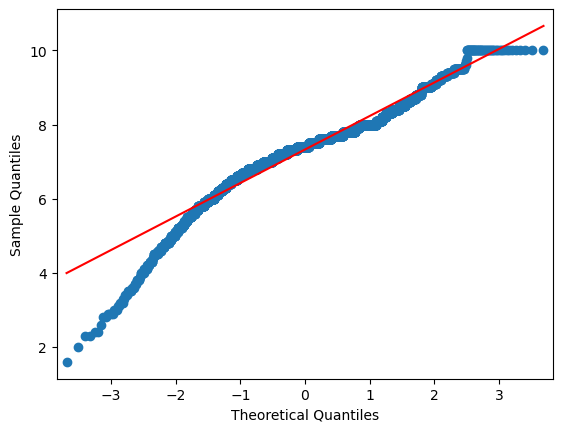

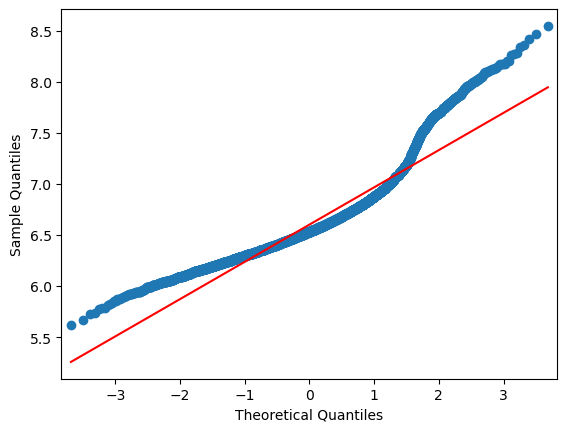

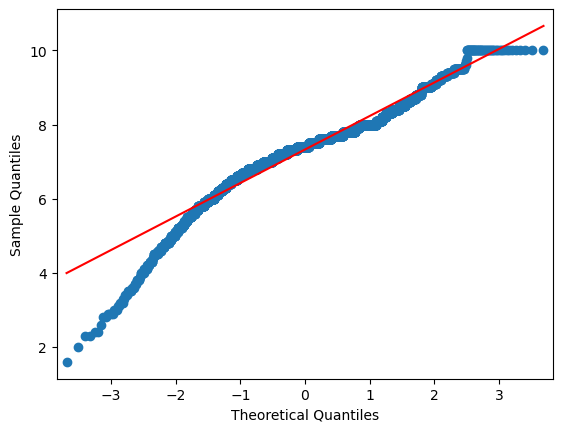

In [102]:
sm.qqplot(df1['log_length'], line='s')
sm.qqplot(df1['score'], line='s')

In [100]:
df1['log_length'] = np.log(df1['length'])
px.scatter(df1, x="log_length", y="score", color='review_release_difference')

/var/folders/22/tmh4hgv57j97065jqsnx1qm40000gp/T/ipykernel_30949/3377063544.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [119]:
smf.ols('score ~ length + review_release_difference + followers_count + reviewer_reviews', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     514.3
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:42:02   Log-Likelihood:                -10652.
No. Observations:                8791   AIC:                         2.131e+04
Df Residuals:                    8786   BIC:                         2.135e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.7981      0.024    278.515      0.000       6.750       6.846
length                        0.0006   3.02e-05     20.811      0.000       0.001       0.001
review_release_difference     0.0193      0.002     12.516      0.000       0.016       0.022
followers_count           -1.035e-08   7.71e-10    -13.427      0.000   -1.19e-08   -8.84e-09
reviewer_reviews              0.0002   8.93e-05      2.016      0.044       5e-06       0.000
==============================================================================
Omnibus:                     2573.309   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9888.651
Skew:                          -1.418   Prob(JB):                         0.00
Kurtosis:                       7.353   Cond. No.                     3.31e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

20.697801689947273 [  0.         -13.45892683 -11.30776504 -13.65128692]


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but SplineTransformer was fitted with feature names



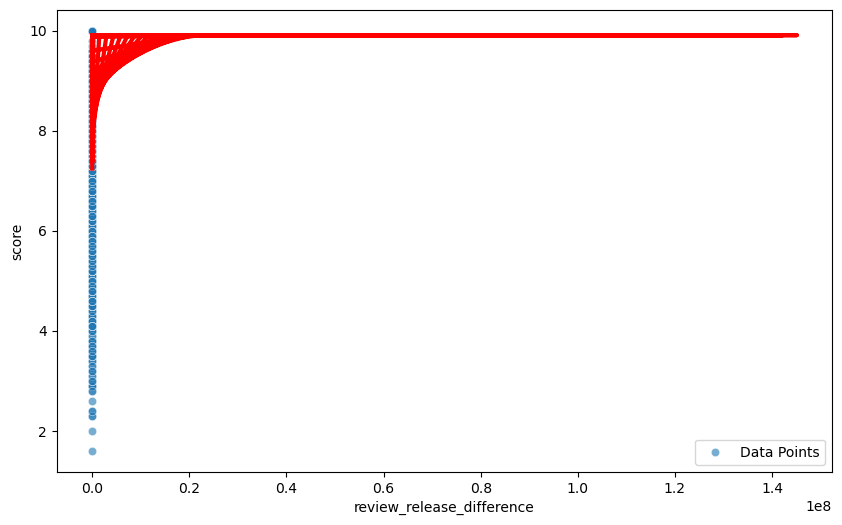

In [ ]:
spline_transformer = SplineTransformer(
    degree=3, 
    n_knots=3, 
    knots='quantile',
    include_bias=False
)

X_spline = spline_transformer.fit_transform(df1[['review_release_difference']])

model = LinearRegression().fit(X_spline, y)

X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_plot_spline = spline_transformer.transform(X_plot)
y_pred = model.predict(X_plot_spline)
print(model.intercept_, model.coef_)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_release_difference', y='score', data=df1, alpha=0.6, label='Data Points')
plt.plot(X_plot, y_pred, color='red', linewidth=3, label='Cubic Spline Fit (SplineTransformer)')


--- A. Key Visualizations ---


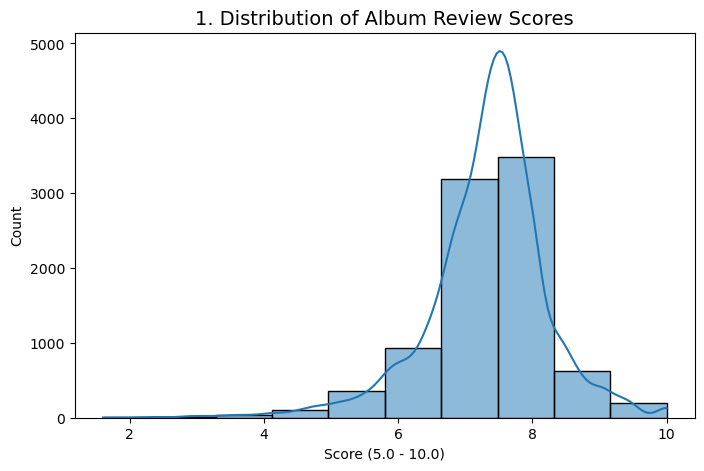

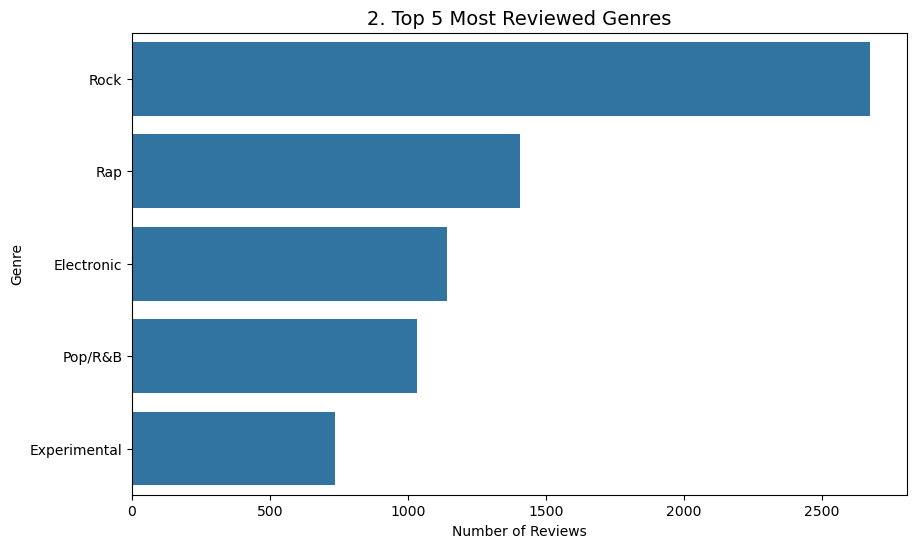

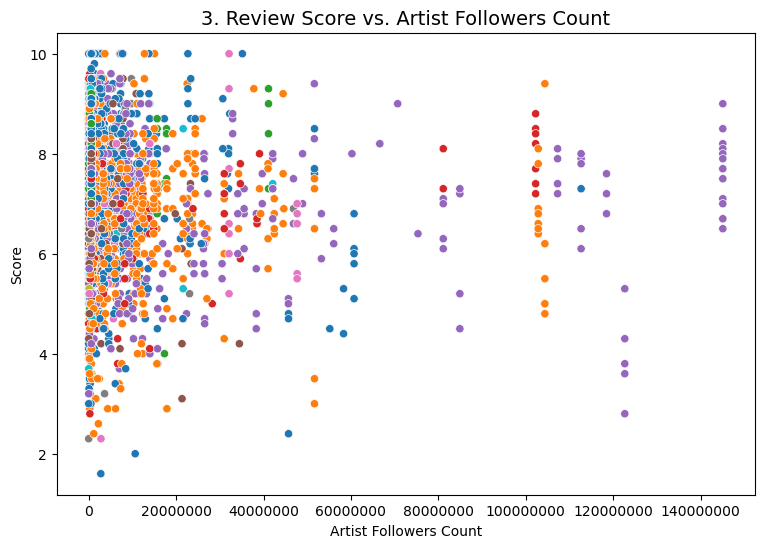

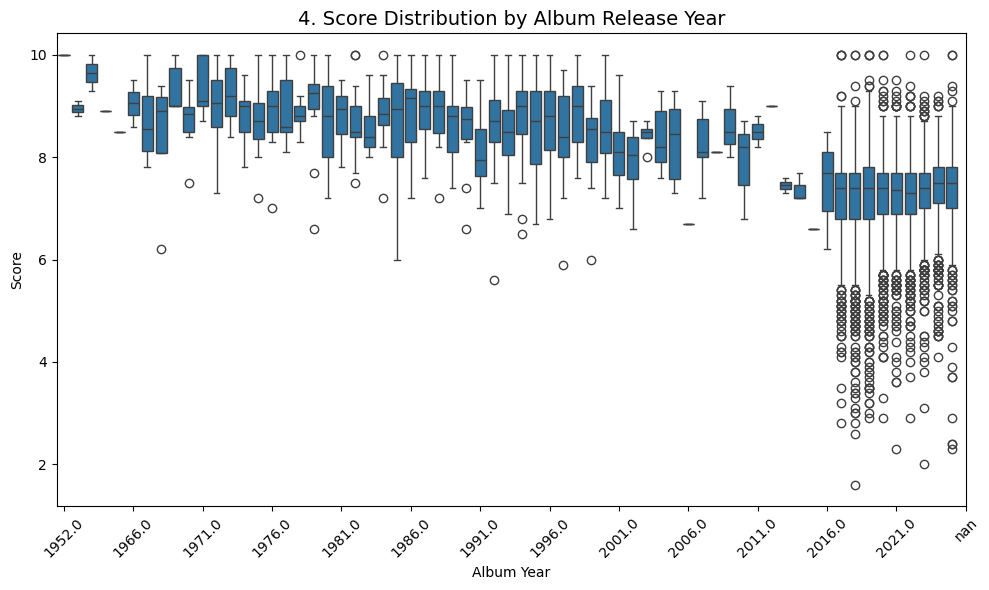

In [ ]:
# 1. Distribution of Review Scores
plt.figure(figsize=(8, 5))
sns.histplot(df['score'].dropna(), bins=10, kde=True, edgecolor='black')
plt.title('1. Distribution of Album Review Scores', fontsize=14)
plt.xlabel('Score (5.0 - 10.0)')
plt.ylabel('Count')
plt.show()

# 2. Countplot of Top 5 Genres
plt.figure(figsize=(10, 6))
sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index[:5])
plt.title('2. Top 5 Most Reviewed Genres', fontsize=14)
plt.xlabel('Number of Reviews')
plt.ylabel('Genre')
plt.show()

# 3. Score vs. Artist Followers Count (for relationship checking)
plt.figure(figsize=(9, 6))
sns.scatterplot(x='followers_count', y='score', data=df, hue='genre', palette='tab10', legend=False)
plt.title('3. Review Score vs. Artist Followers Count', fontsize=14)
plt.xlabel('Artist Followers Count')
plt.ylabel('Score')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# 4. Album Year vs. Score (Time-based analysis)
plt.figure(figsize=(10, 6))
sns.boxplot(x='album_year', y='score', data=df.sort_values('album_year'))
# Show only a few ticks on the x-axis for readability
ticks = df['album_year'].unique()
ticks.sort()
plt.xticks(np.arange(len(ticks))[::5], ticks[::5], rotation=45)
plt.title('4. Score Distribution by Album Release Year', fontsize=14)
plt.xlabel('Album Year')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [117]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
top_10_genres = df['genre'].value_counts().nlargest(10).index
df_filtered = df[df['genre'].isin(top_10_genres)].copy()
genre_scores = [
    df['score'][df['genre'] == g].dropna()
    for g in top_10_genres
]

f_statistic, p_value = f_oneway(*genre_scores)
print("\n--- Concise ANOVA Results (Top 10 Genres) ---")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4e}")

tukey_results = pairwise_tukeyhsd(
    endog=df_filtered['score'],       # The data (scores)
    groups=df_filtered['genre'],      # The groups (genres)
    alpha=0.05                        # Significance level
)
print(tukey_results)


--- Concise ANOVA Results (Top 10 Genres) ---
F-statistic: 35.0267
P-value: 2.7860e-61
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
               Electronic Electronic / Experimental  -0.0181    1.0 -0.3397  0.3035  False
               Electronic         Electronic / Rock  -0.0238    1.0 -0.3614  0.3138  False
               Electronic              Experimental    0.181 0.0006  0.0487  0.3132   True
               Electronic              Folk/Country   0.1395  0.167  -0.023   0.302  False
               Electronic                      Jazz   0.4001    0.0  0.2019  0.5984   True
               Electronic                     Metal   0.1052 0.8961  -0.118  0.3284  False
               Electronic                   Pop/R&B  -0.1944    0.0 -0.3145 -0.0743   True
  

Mixed effects Model for Reviewers by adjusting y-int

Classify into genres (Tukey HSD by score), maybe do KNN